In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("../src")
import data

plt.style.use("seaborn")


In [2]:
df_geo = gpd.read_file(os.path.join("..", "geo", "shapefiles", "kreisgrenzen_2019-shp", "Kreisgrenzen_2019.shp"))
df_raw = data.load_data()

In [25]:
df = df_raw[df_raw.columns[1:]]
df = df.drop_duplicates()
df = df.sort_values("kreis_key").reset_index(drop=True)
df = df[["kreis_key", "kreis_name",  "income_pp_2018", "income_2018", "crimes_2018", "population_2018", "crimes_pp_2018"]]
df = df.dropna()
df.kreis_key = df.kreis_key.astype(int).astype(str).str.zfill(5)
df.income_2018 = pd.to_numeric(df.income_2018)
df.population_2018 = pd.to_numeric(df.population_2018)
df.crimes_2018 = pd.to_numeric(df.crimes_2018)

In [26]:
df_abs = df[["kreis_key", "income_2018", "population_2018", "crimes_2018"]]

In [27]:
df_abs.head()

kreis_key  income_2018  population_2018  crimes_2018
0     01001      1671015            89012       8156.0
1     01002      4804347           247746      24621.0
2     01003      4361215           216758      22685.0
3     01004      1570313            79411      10688.0
4     01051      2999606           133329       7224.0

In [28]:
df_comb = df_geo.merge(df_abs, left_on = "RS", right_on = "kreis_key", how = "left", validate ="one_to_one")

In [29]:
df_comb.head()

FID     RS    AGS        SDV_RS           GEN               BEZ  IBZ BEM  \
0    1  01001  01001  010010000000     Flensburg  Kreisfreie Stadt   40  --   
1    2  01002  01002  010020000000          Kiel  Kreisfreie Stadt   40  --   
2    3  01003  01003  010030000000        Lübeck  Kreisfreie Stadt   40  --   
3    4  01004  01004  010040000000    Neumünster  Kreisfreie Stadt   40  --   
4    5  01051  01051  010510044044  Dithmarschen             Kreis   42  --   

  SN_L SN_R  ... FK_S3   NUTS         WSK SHAPE_Leng SHAPE_Area  \
0   01    0  ...     R  DEF01  2008-01-01   0.524721   0.006873   
1   01    0  ...     R  DEF02  2006-01-01   1.274684   0.015507   
2   01    0  ...     R  DEF03  2006-02-01   1.834534   0.028928   
3   01    0  ...     R  DEF04  1970-04-26   0.663262   0.009808   
4   01    0  ...     R  DEF05  2011-08-01   3.073353   0.196087   

                                            geometry kreis_key  income_2018  \
0  POLYGON ((9.41266 54.82264, 9.41318 54.82124, ...     01001      1671015   
1  POLYGON ((10.16916 54.43138, 10.16957 54.43067...     01002      4804347   
2  POLYGON ((10.87684 53.98737, 10.87884 53.98595...     01003      4361215   
3  POLYGON ((9.99545 54.14972, 9.99713 54.14806, ...     01004      1570313   
4  MULTIPOLYGON (((9.07402 54.36277, 9.07595 54.3...     01051      2999606   

   population_2018 crimes_2018  
0            89012      8156.0  
1           247746     24621.0  
2           216758     22685.0  
3            79411     10688.0  
4           133329      7224.0  

[5 rows x 24 columns]

In [30]:
df_comb["bl_key"] = df_comb.kreis_key.str.slice(0, 2)

In [33]:
df_coarse = df_comb.dissolve(by="bl_key", aggfunc = "sum")

In [34]:
df_coarse.head()

geometry   FID   IBZ  \
bl_key                                                                  
01      MULTIPOLYGON (((9.52651 53.66575, 9.52685 53.6...   120   622   
02      MULTIPOLYGON (((9.73136 53.55775, 9.73204 53.5...    16    40   
03      MULTIPOLYGON (((10.67728 51.63838, 10.67531 51...  1755  1913   
04      MULTIPOLYGON (((8.53948 53.60629, 8.55483 53.6...   125    80   
05      MULTIPOLYGON (((6.20511 50.52197, 6.20533 50.5...  4770  2186   

        SHAPE_Leng  SHAPE_Area  income_2018  population_2018  crimes_2018  
bl_key                                                                     
01       47.465611    2.149695     66062082          2893271     186894.0  
02        3.124420    0.100118     45949850          1835882     216569.0  
03      121.680067    6.344947    175305662          7972623     498092.0  
04        2.660674    0.054104     14650380           682009      74307.0  
05      101.555929    4.413422    399569604         17922405    1250805.0

In [41]:
df_coarse["crimes_pp_2018"] = df_coarse.crimes_2018 / df_coarse.population_2018

df_coarse["income_pp_2018"] = df_coarse.income_2018 / df_coarse.population_2018


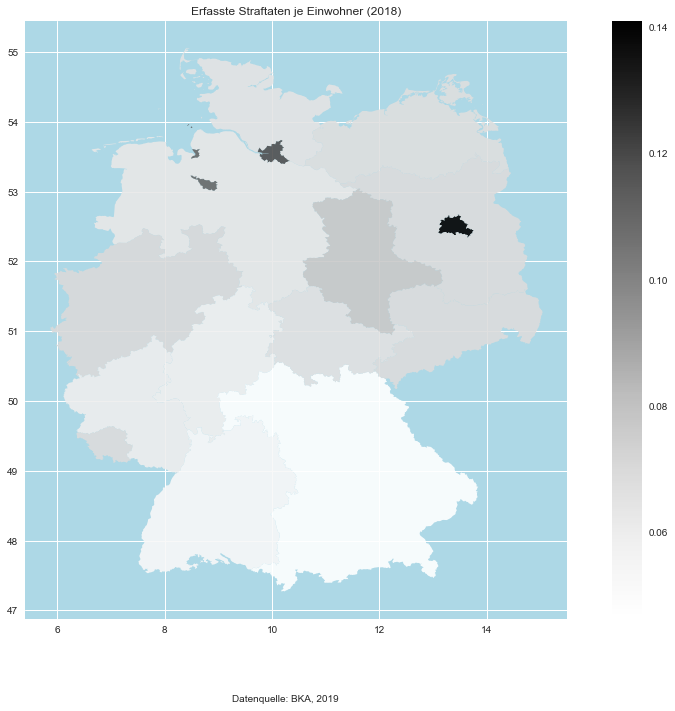

In [38]:
plt.rcParams["figure.figsize"] = [16, 11]

fig, ax = plt.subplots()

df_coarse.plot(
    ax=ax, 
    column='crimes_pp_2018',
    alpha=0.9,
    legend = True
)

ax.set(
    title='Erfasste Straftaten je Einwohner (2018)', 
    aspect=1.3, 
    facecolor='lightblue'
);

plt.figtext(0.5, 0.02, "Datenquelle: BKA, 2019", ha="center", fontsize=10)

plt.savefig(os.path.join("..", "output", "crimes_bl_pp_2018.png"))

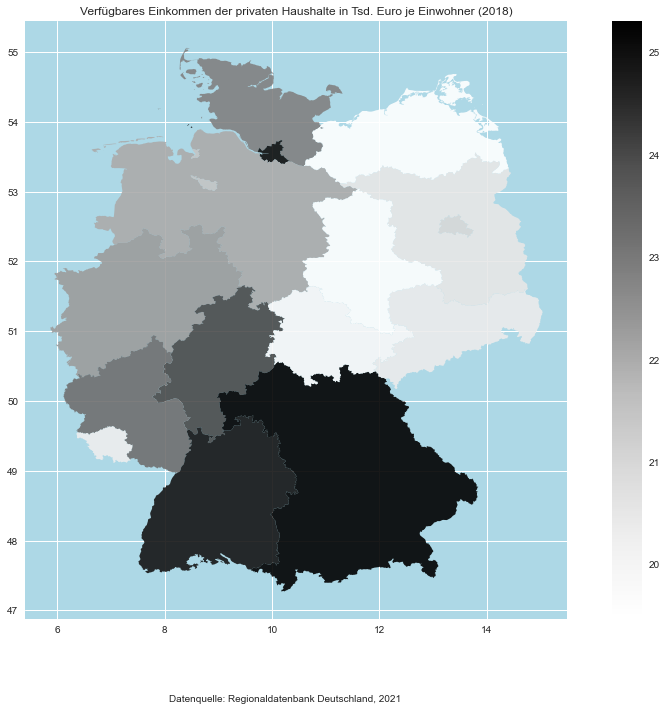

In [45]:
fig, ax = plt.subplots()

df_coarse.plot(
    ax=ax, 
    column='income_pp_2018',
    alpha=0.9,
    legend = True
)

ax.set(
    title='Verfügbares Einkommen der privaten Haushalte in Tsd. Euro je Einwohner (2018)', 
    aspect=1.3, 
    facecolor='lightblue'
);

plt.figtext(0.5, 0.02, "Datenquelle: Regionaldatenbank Deutschland, 2021", ha="center", fontsize=10)

plt.savefig(os.path.join("..", "output", "income_bl_pp_2018.png"))